In [1]:
from collections import OrderedDict

import os
import cv2
import torch
import argparse
import numpy as np
from PIL import Image
from scipy.ndimage import zoom
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

In [2]:
from ops import (
    TSNDataSet, TSN, return_dataset,
    AverageMeter, accuracy, make_temporal_pool,
    GroupNormalize, GroupScale, GroupCenterCrop, 
    IdentityTransform, Stack, ToTorchFormatTensor
)

In [3]:
import torchvision

In [4]:
def load_images(frame_dir, selected_frames, transform1, transform2):
    images = np.zeros((8, 256, 256, 3))
    orig_imgs = np.zeros_like(images)
    images_group = list()
    for i, frame_name in enumerate(selected_frames):
        im_name = os.path.join(frame_dir, frame_name)
        img = Image.open(im_name).convert('RGB')
        images_group.append(img)
        r_image = np.array(img)[:,:,::-1]
        orig_imgs[i] = transform2([Image.fromarray(r_image)])  
    torch_imgs = transform1(images_group)
    return np.expand_dims(orig_imgs, 0), torch_imgs

In [5]:
def get_index(num_frames, num_segments):
    if num_frames > num_segments:
        tick = num_frames / float(num_segments)
        offsets = np.array([int(tick / 2.0 + tick * x) for x in range(num_segments)])
    else:
        offsets = np.zeros((num_segments,))
    return offsets + 1

In [21]:
cd /home/ckli/my_try/CT_Net/demo

/home/ckli/my_try/CT_Net/demo


In [22]:
label_file = '../data/something/category.txt'
category = []
for x in open(label_file):
    category.append(x.rstrip())
num_class = len(category)

In [23]:
weights = '../model/ct_net_8f_r50.pth.tar'
model = TSN(174, 8, 'RGB', 'CT_Net', backbone='resnet50', consensus_type='avg',
            dropout=0.5, partial_bn=False, aggregation='sum', 
            pretrain='ImageNet', diff_div=4, fc_lr5=True, temporal_pool=False, non_local=False,
            num_total=7, full_res=True)
checkpoint = torch.load(weights, map_location=torch.device('cpu'))
pretrained_dict = checkpoint['state_dict']
new_state_dict = OrderedDict()
for k, v in pretrained_dict.items():
    name = k[7:]  # remove 'module.'
    # name = name.replace('.net', '')
    new_state_dict[name] = v
model.load_state_dict(new_state_dict)
model.eval()


    Initializing TSN with base model: resnet50.
    TSN Configurations:
        input_modality:     RGB
        num_segments:       8
        new_length:         1
        consensus_module:   avg
        dropout_ratio:      0.5
            
=> backbone: resnet50
=> base model: CT_Net
Freeze the pretrained parameters...
Replacing original block to 7 new block...
parallel, spatiotemporal plus
parallel, spatiotemporal plus
parallel, spatiotemporal plus
parallel, spatiotemporal plus
parallel, spatiotemporal plus
parallel, spatiotemporal plus
parallel, spatiotemporal plus


In [11]:
# load image
crop_size = model.crop_size
scale_size = model.scale_size
input_mean = model.input_mean
input_std = model.input_std

transform1 = torchvision.transforms.Compose([
    GroupScale(int(scale_size)),
    GroupCenterCrop(crop_size),
    Stack(),
    ToTorchFormatTensor(),
    GroupNormalize(input_mean, input_std) 
])

transform2 = torchvision.transforms.Compose([
    GroupScale(int(scale_size)),
    GroupCenterCrop(crop_size),
    Stack()
])

In [12]:
def get_img(frame_dir, label):
    frame_names = os.listdir(frame_dir)
    frame_indices = get_index(len(frame_names), 8)
    selected_frames = ['{:05d}.jpg'.format(i) for i in frame_indices]

    RGB_vid, vid = load_images(frame_dir, selected_frames, transform1, transform2)
    
    return RGB_vid, vid

In [16]:
def get_heatmap(RGB_vid, vid, label):
    # get predictions, last convolution output and the weights of the prediction layer
    predictions = model(vid)
    layerout = model.base_model.layerout
    layerout = torch.tensor(layerout.numpy().transpose(0, 2, 3, 1))
    pred_weights = model.new_fc.weight.data.detach().cpu().numpy().transpose()

    pred = torch.argmax(predictions).item()

    cam = np.zeros(dtype = np.float32, shape = layerout.shape[0:3])
    for i, w in enumerate(pred_weights[:, label]):
        # Compute cam for every kernel
        cam += w * layerout[:, :, :, i].numpy()

    # Resize CAM to frame level
    cam = zoom(cam, (1, 32, 32)) # output map is 8x7x7, so multiply to get to 16x224x224 (original image size)

    # normalize
    cam -= np.min(cam)
    cam /= np.max(cam) - np.min(cam)

    heatmaps = []
    for i in range(0, cam.shape[0]):
        #   Create colourmap
        heatmap = cv2.applyColorMap(np.uint8(255*cam[i]), cv2.COLORMAP_JET)

        # Create frame with heatmap
        heatframe = heatmap//2 + RGB_vid[0][i]//2
        heatmaps.append(heatframe[:, :, ::-1]/255.)
        
    return heatmaps, pred

In [17]:
def show_cam(frame_dir, label):
    RGB_vid, vid = get_img(frame_dir=frame_dir , label=label)
    heatmaps, pred = get_heatmap(RGB_vid, vid, label=label)
    print("Visualizing for class\t{}-{}".format(label, category[label]))
    print(("CT-Net predicted class\t{}-{}".format(pred, category[pred])))
    plt.rcParams['savefig.dpi'] = 200 #图片像素
    plt.rcParams['figure.dpi'] = 200 #分辨率
    plt.figure()
    gs=gridspec.GridSpec(1,8)
    for i in range(1):
        for j in range(8):
            plt.subplot(gs[i,j])
            temp = RGB_vid[0][i*4+j]
            plt.imshow(temp[:,:,::-1]/255.)
            plt.axis('off')
    plt.title('Origin')
    plt.show()

    plt.rcParams['savefig.dpi'] = 200 #图片像素
    plt.rcParams['figure.dpi'] = 200 #分辨率
    plt.figure()
    gs=gridspec.GridSpec(1,8)
    for i in range(1):
        for j in range(8):
            plt.subplot(gs[i,j])
            plt.imshow(heatmaps[i*8+j])
            plt.axis('off')
    plt.title('CT-Net')
    plt.show()

Visualizing for class	0-Approaching something with your camera
CT-Net predicted class	0-Approaching something with your camera


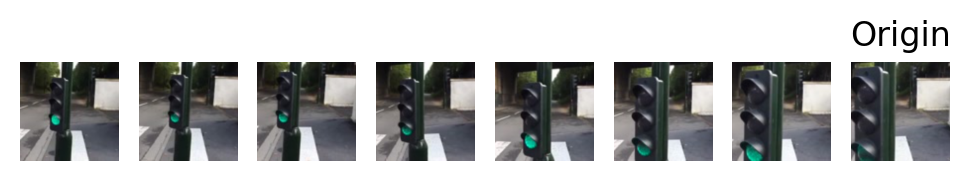

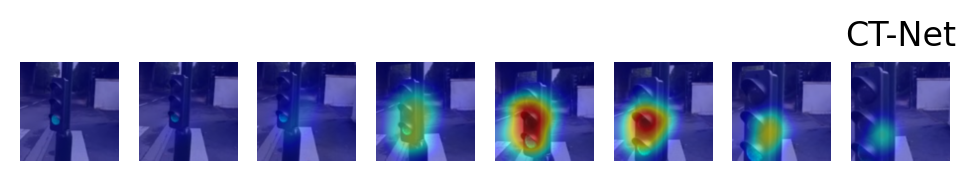

In [24]:
show_cam(frame_dir='./video_data/79255', label=0)

Visualizing for class	32-Moving away from something with your camera
CT-Net predicted class	32-Moving away from something with your camera


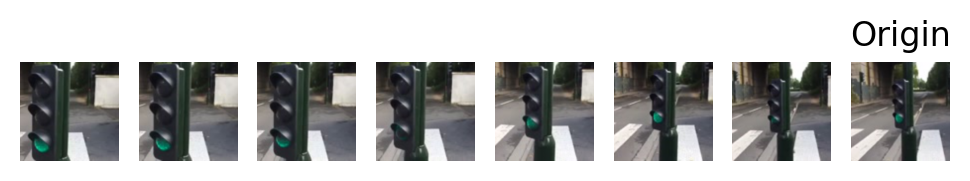

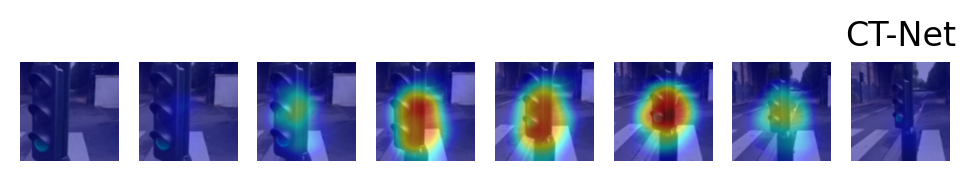

In [19]:
show_cam(frame_dir='./video_data/79255', label=32)

Visualizing for class	167-Turning the camera right while filming something
CT-Net predicted class	167-Turning the camera right while filming something


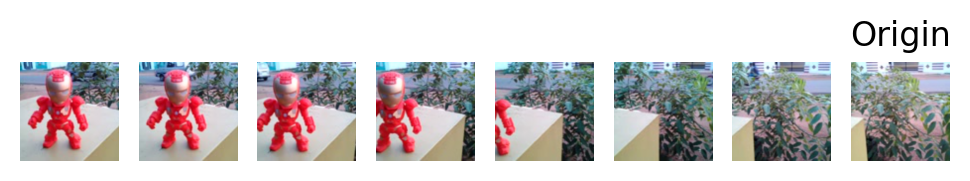

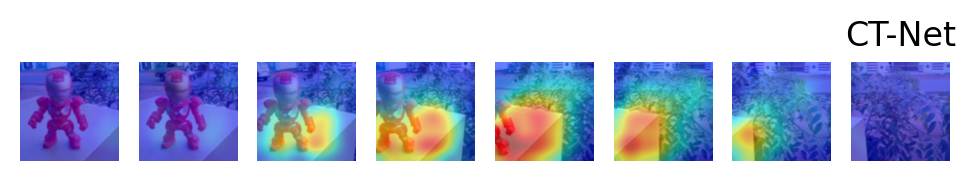

In [20]:
show_cam(frame_dir='/data1/ckli/sthv1/6106', label=167)